In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, f1_score
from sklearn.preprocessing import label_binarize

In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [15]:
def load_data(features_path, labels_path):
    """Load gene expression data and cancer type labels."""
    features = pd.read_csv(features_path)
    labels = pd.read_csv(labels_path)
    
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    
    X = features.values
    y = labels['Cancer_Type'].values
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    cancer_types = label_encoder.classes_
    print(f"Cancer types: {cancer_types}")
    print(f"Number of cancer types: {len(cancer_types)}")
    
    return X, y_encoded, cancer_types

In [16]:
def create_dataset(features, labels):
    """Create dataset as a list of tuples."""
    dataset = [(torch.FloatTensor(features[i]), torch.LongTensor([labels[i]])) for i in range(len(features))]
    return dataset

In [17]:
def build_model(input_dim, hidden_dims, output_dim, dropout_rate=0.5):
    """Build a neural network model."""
    layers = []
    prev_dim = input_dim
    
    for hidden_dim in hidden_dims:
        layers.append(nn.Linear(prev_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.Dropout(dropout_rate))
        prev_dim = hidden_dim
    
    layers.append(nn.Linear(prev_dim, output_dim))
    
    model = nn.Sequential(*layers)
    print(model)
    return model

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=10):
    """Train the model with early stopping."""
    model.to(device)
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    pat_epochs = 0
    
    for epoch in range(num_epochs):
        model.train()
        r_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).squeeze()
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            r_loss += loss.item() * inputs.size(0)
        
        train_loss = r_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).squeeze()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            pat_epochs = 0
        else:
            pat_epochs += 1
        
        # Early stopping
        if pat_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Load best model
    model.load_state_dict(best_model_wts)
    
    return model, train_losses, val_losses, val_accuracies

In [19]:
def plot_training_history(train_losses, val_losses, val_accuracies):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(val_accuracies, label='Validation Accuracy', color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [20]:
def evaluate_model(model, test_loader, criterion, device):
    """Evaluate model performance on test set."""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).squeeze()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct / total
    
    return test_loss, test_accuracy, all_preds, all_labels

In [21]:
def plot_confusion_matrix(all_labels, all_preds, cancer_types):
    """Plot confusion matrix."""
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=cancer_types, yticklabels=cancer_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

Features shape: (2952, 11312)
Labels shape: (2952, 2)
Cancer types: ['BLCA' 'CESC' 'GBM' 'HNSC' 'KIRC' 'LGG']
Number of cancer types: 6

Training set size: 2066
Validation set size: 590
Test set size: 296
Sequential(
  (0): Linear(in_features=11312, out_features=1024, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=128, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=6, bias=True)
)

Model architecture:
Sequential(
  (0): Linear(in_features=11312, out_features=1024, bias=True)
  (1): ReLU()
  (2): B

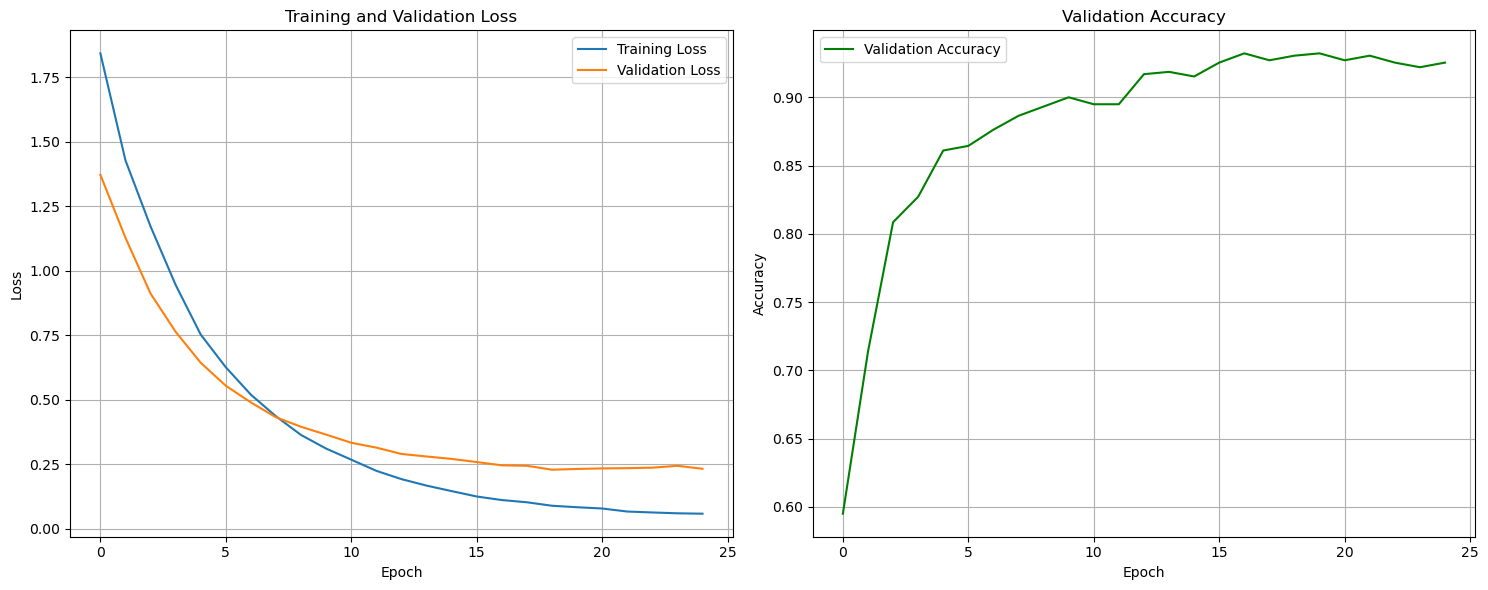


Test Loss: 0.1814
Test Accuracy: 0.9595


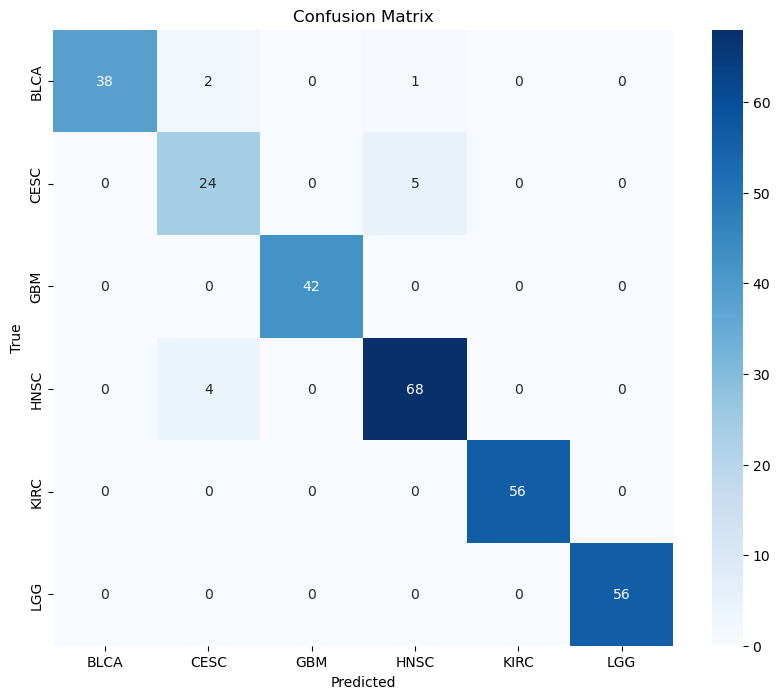

Model saved to gene_expression_model.pth


/var/folders/hv/9s8r3rt15_xg0cd2g8jmr9m00000gn/T/ipykernel_55486/1034576076.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


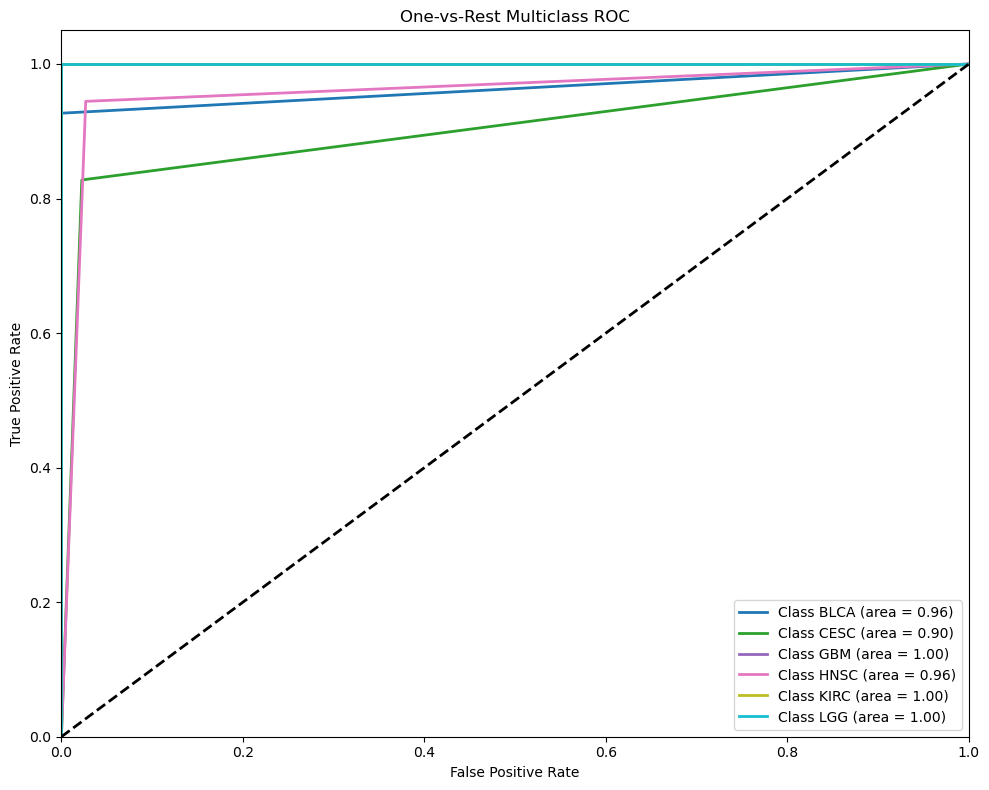

Balanced Accuracy: 0.9498
Macro F1 Score: 0.9512


In [22]:
def main():
    """Main function to run the entire pipeline."""
    features_path = 'features.csv'
    labels_path = 'labels.csv'
    
    # Hyperparameters
    batch_size = 64
    learning_rate = 0.0001
    weight_decay = 1e-5
    num_epochs = 1000
    hidden_dims = [512*2, 512, 128]
    dropout_rate = 0.5
    patience = 6
    
    # Load and preprocess data
    X, y, cancer_types = load_data(features_path, labels_path)
    dataset = create_dataset(X, y)
    
    # Split into train/val/test
    total = len(dataset)
    train_size = int(0.7 * total)
    val_size = int(0.2 * total)
    test_size = total - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    print(f"\nTraining set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    input_dim = X.shape[1]
    output_dim = len(cancer_types)
    model = build_model(input_dim, hidden_dims, output_dim, dropout_rate)
    
    # Print model summary
    print("\nModel architecture:")
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Train model
    print("\nTraining model...")
    start_time = time.time()
    best_model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot training history
    plot_training_history(train_losses, val_losses, val_accuracies)
    
    # Evaluate on test set
    test_loss, test_accuracy, all_preds, all_labels = evaluate_model(
        best_model, test_loader, criterion, device
    )
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, cancer_types)
    
    # Save model
    model_path = 'gene_expression_model.pth'
    torch.save({
        'model_state_dict': best_model.state_dict(),
        'input_dim': input_dim,
        'hidden_dims': hidden_dims,
        'output_dim': output_dim,
        'dropout_rate': dropout_rate,
        'cancer_types': cancer_types,
    }, model_path)
    print(f"Model saved to {model_path}")



    n_classes = len(cancer_types)
    y_true_bin = label_binarize(all_labels, classes=np.arange(n_classes))
    y_pred_bin = label_binarize(all_preds, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area 
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                label=f'Class {cancer_types[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('One-vs-Rest Multiclass ROC')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('multiclass_roc.png')
    plt.show()

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    print(f'Balanced Accuracy: {balanced_acc:.4f}')

    # Macro F1
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'Macro F1 Score: {macro_f1:.4f}')




    

if __name__ == "__main__":
    main()